In [1]:
library(readxl)
library(tidyr)
library(tidyverse)
library(caret)

# Suppress warnings globally
options(warn = -1)

# set working directory
# setwd('/lustre/home/reynaj/Projects/20241011.Byrd_Lab.IBD_NuLisa')
setwd('/home/reynaj/projects/kevin_byrd/20241011.kevin_byrd.ibd_nulisa')

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.4
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.2     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




## Process the protein levels

In [2]:
# load assay data
fn <- "results/raw/P-000458_ADA_NULISAseq_Inflammation Panel_1-NPQ Counts_2-Target Detectability_3-Sample Information_2024_08_26.xlsx"
data <- read_excel(fn, sheet = "NPQ Counts");

In [3]:
data[1:3,]

Panel,PanelLotNumber,PlateID,SampleName,SampleType,Target,AlamarTargetID,UniProtID,ProteinName,SampleQC,LOD,NPQ
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
200-Plex Inflammation Panel v2,panelLot022,Plate_01,A_01_TRP-34082,Sample,AGER,t5521,Q15109,Advanced glycosylation end product-specific receptor,PASS,0,5.493463
200-Plex Inflammation Panel v2,panelLot022,Plate_01,A_02_TRP-34086,Sample,AGER,t5521,Q15109,Advanced glycosylation end product-specific receptor,PASS,0,4.453723
200-Plex Inflammation Panel v2,panelLot022,Plate_01,A_03_TRP-42335,Sample,AGER,t5521,Q15109,Advanced glycosylation end product-specific receptor,PASS,0,6.469100


In [4]:
# remove the control samples
pd_data <- data %>% filter(!SampleName %in% c('A_12_SC_Rep01', 'B_12_SC_Rep02', 'C_12_SC_Rep03'))

# generate indicator of whether NPQ < LOD
pd_data <- pd_data %>% mutate(NPQ_below_LOD = NPQ < LOD)

# calculate the number of samples
num_samples <- nrow(unique(pd_data[,'SampleName']))

protein_detectability <- pd_data %>% group_by(Target) %>%
                            summarise(portion_NPQ_below_LOD = sum(NPQ_below_LOD) / num_samples) %>%
                            arrange(desc(portion_NPQ_below_LOD))

low_protein_detectability <- protein_detectability[protein_detectability[,'portion_NPQ_below_LOD'] >= 0.5,] %>% drop_na()
high_protein_detectability <- protein_detectability[protein_detectability[,'portion_NPQ_below_LOD'] < 0.5,] %>% drop_na()

In [5]:
nrow(high_protein_detectability)

[1] 230

In [6]:
nrow(low_protein_detectability)

[1] 18

In [7]:
# filter for only good proteins
filtered_data <- data %>% filter(Target %in% high_protein_detectability$Target)

# pivot the data to make a matrix
wide_data <- filtered_data %>% pivot_wider(id_cols = SampleName, names_from = Target, values_from = NPQ)

In [8]:
# transpose the data to be in the correct format for limma
# rows = genes
# columns = samples
t_data = t(wide_data)

# clean up the first row
colnames(t_data) <- t_data[1,]
t_data <- as.data.frame(t_data[-1,])

# get the column names
sample_names <- colnames(t_data)

# remove the pattern [A-Z]_[0-9]+
new_sample_names <- gsub("[A-Z]_[0-9]+_", "", sample_names)

# assign the new column names back to the data frame
colnames(t_data) <- new_sample_names

In [9]:

# # check near zero variance # didn't find any zeroVar nor nzv
nzv_info <- nearZeroVar(t(t_data), saveMetrics = TRUE)
lapply(nzv_info, sum)


$freqRatio
[1] 1562

$percentUnique
[1] 21410.11

$zeroVar
[1] 0

$nzv
[1] 0

In [10]:
write.table(t_data, "results/specimen_focused/comp_data/protein_levels.230_prots.npq.tsv", sep = "\t", col.names = TRUE, quote=FALSE)

### Excluded protein data

In [11]:
clinical_data <- read.table("results/specimen_focused/comp_data/clinical_data.tsv", sep='\t', header=TRUE)

In [12]:
clinical_data

project_name,sample_type,sample_id,collection_date,box_id,box_location,total_volume__ml,original_subject_id,event_name,ibd_diagnosis,date_collection,disease_activity,matched_subject_id,notes,ibd_indicator,disease_activity_indicator,max_crp_value,crp_severity
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<lgl>,<chr>,<chr>,<dbl>,<chr>
Byrd_IBD_Saliva_sup,Saliva,TRP-34082,2023-11-30 15:34:05.854,1,A1,1100,TRP-34082,1,CD,2023-11-30,Quiescent,1,NA,IBD Super Group,In-active Disease,1.0,Mild
Byrd_IBD_Saliva_sup,Saliva,TRP-34086,2023-11-30 15:34:05.854,1,A2,1100,TRP-34086,1,CD,2023-11-30,Quiescent,3,NA,IBD Super Group,In-active Disease,1.0,Mild
Byrd_IBD_Saliva_sup,Saliva,TRP-42335,2023-12-20 16:51:00.779,1,A3,1000,TRP-42335,1,CD,2023-12-20,Quiescent,7,NA,IBD Super Group,In-active Disease,1.0,Mild
Byrd_IBD_Saliva_sup,Saliva,TRP-42324,2023-12-20 13:54:07.467,1,A4,1000,TRP-42324,1,UC,2023-12-20,Quiescent,6,NA,IBD Super Group,In-active Disease,9.0,Moderate
Byrd_IBD_Saliva_sup,Saliva,TRP-42322,2023-12-20 13:53:28.319,1,A5,1000,TRP-42322,1,CD,2023-12-20,Quiescent,5,NA,IBD Super Group,In-active Disease,1.0,Mild
Byrd_IBD_Saliva_sup,Saliva,TRP-42320,2023-12-20 13:52:46.153,1,A6,1000,TRP-42320,1,CD,2023-12-20,Quiescent,4,NA,IBD Super Group,In-active Disease,23.0,High
Byrd_IBD_Saliva_sup,Saliva,TRP-42344-2,2024-01-03 16:50:57.498,1,A7,1500,TRP-42344-2,1,CD,2024-01-03,Quiescent,8,NA,IBD Super Group,In-active Disease,9.0,Moderate
Byrd_IBD_Saliva_sup,Saliva,TRP-42346,2024-01-03 16:18:34.612,1,A8,1500,TRP-42346,1,UC,2024-01-03,Moderate,9,NA,IBD Super Group,Active Disease,1.0,Mild
Byrd_IBD_Saliva_sup,Saliva,TRP-42368-1,2024-01-10 15:17:49.284,1,A9,1500,TRP-42368-1,1,CD,2024-01-10,Quiescent,13,NA,IBD Super Group,In-active Disease,1.0,Mild


In [13]:
low_filtered_data <- data %>% filter(Target %in% low_protein_detectability$Target)

In [14]:
# remove the pattern [A-Z]_[0-9]+
low_filtered_data$SampleName <- gsub("[A-Z]_[0-9]+_", "", low_filtered_data$SampleName)

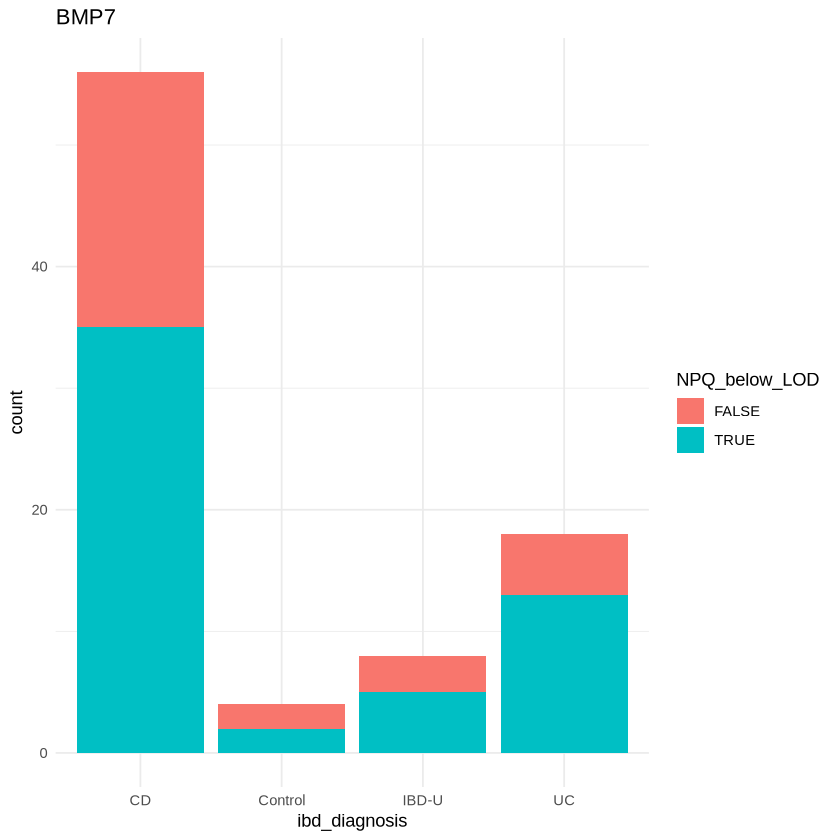

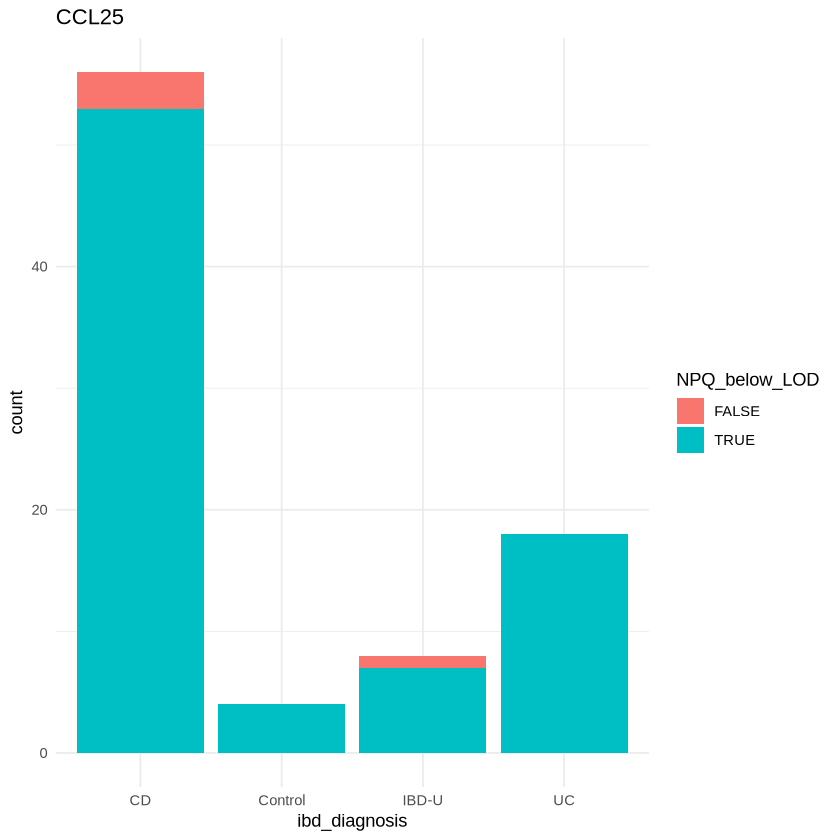

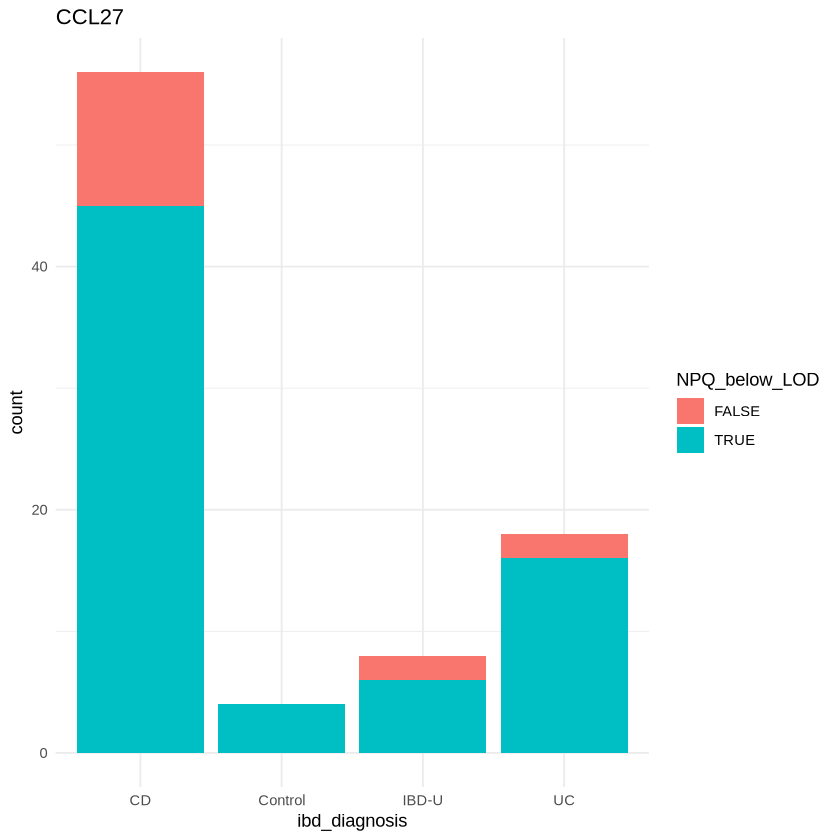

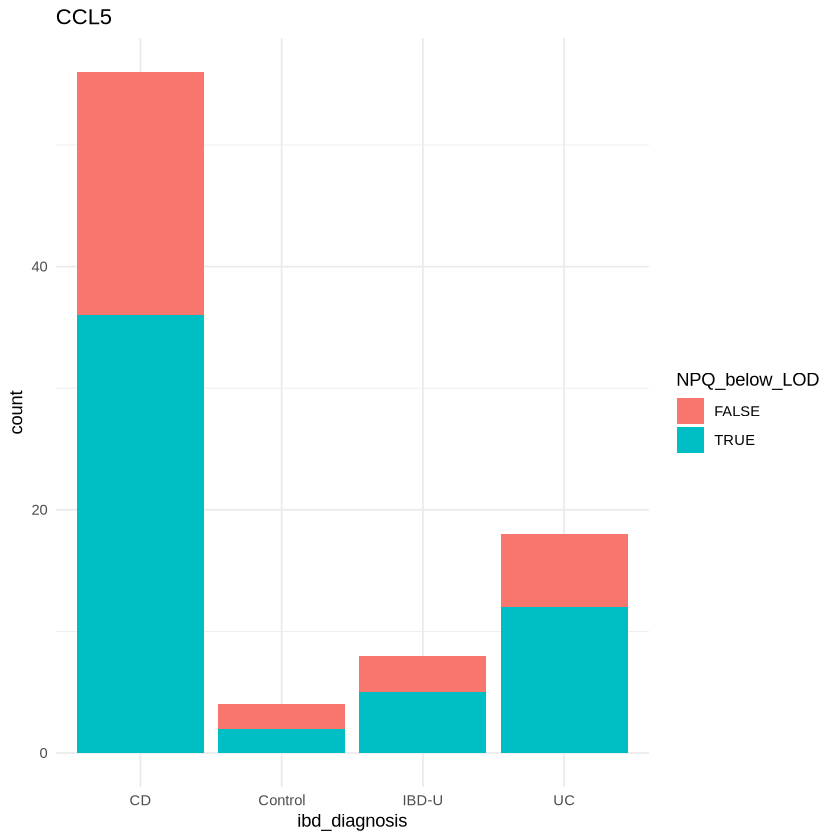

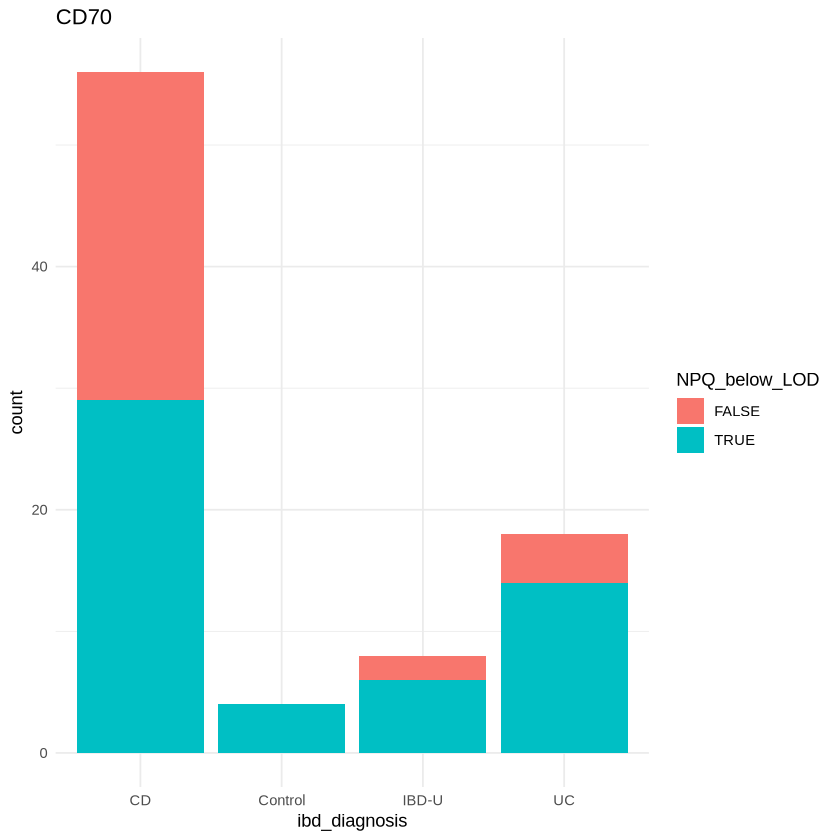

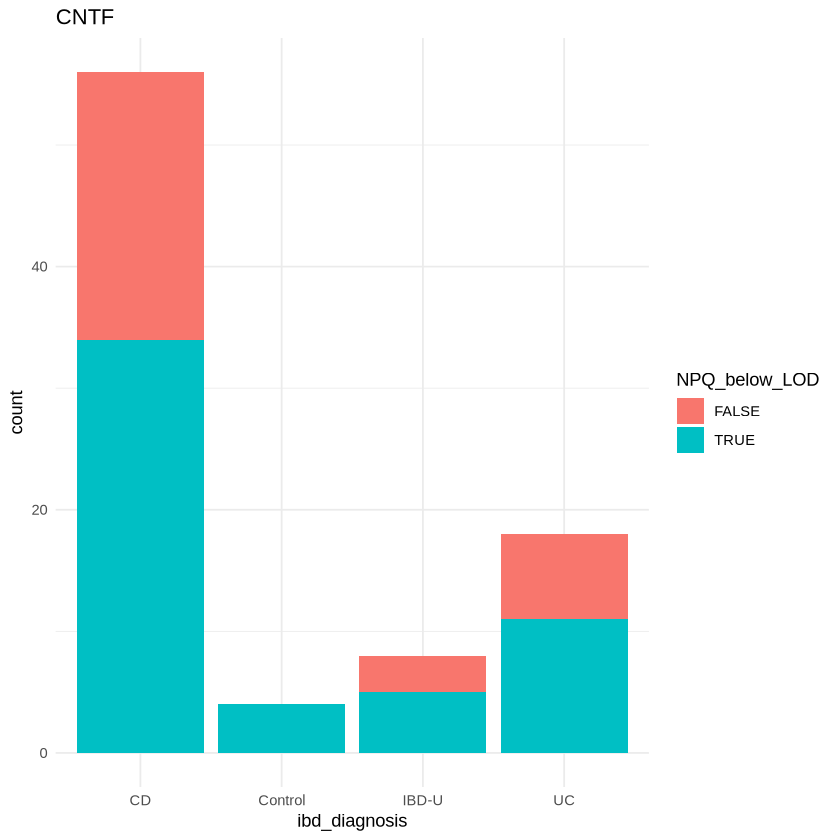

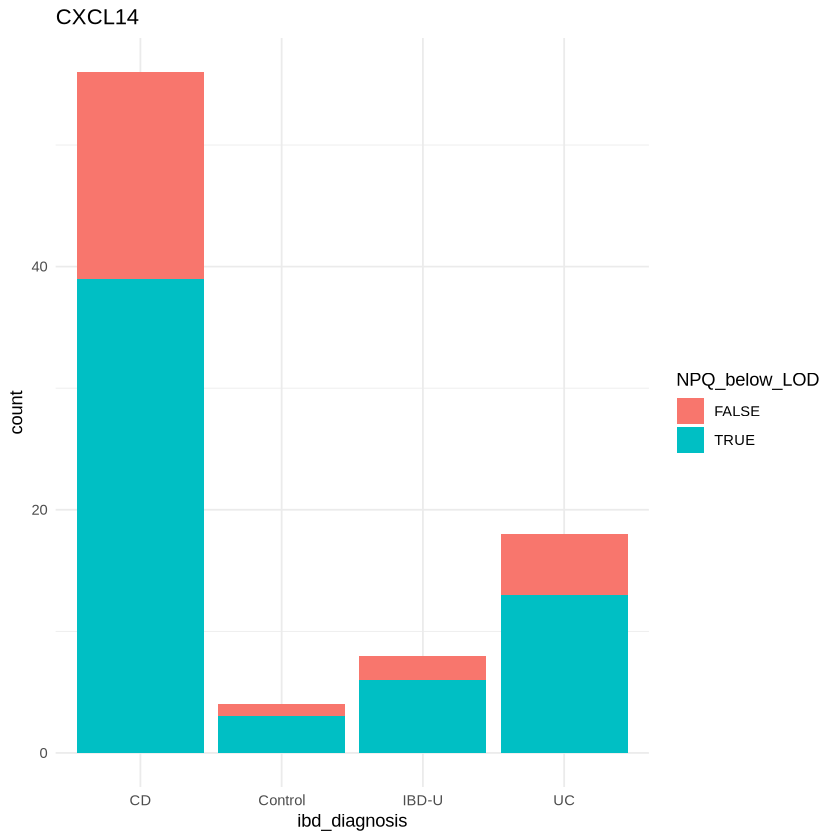

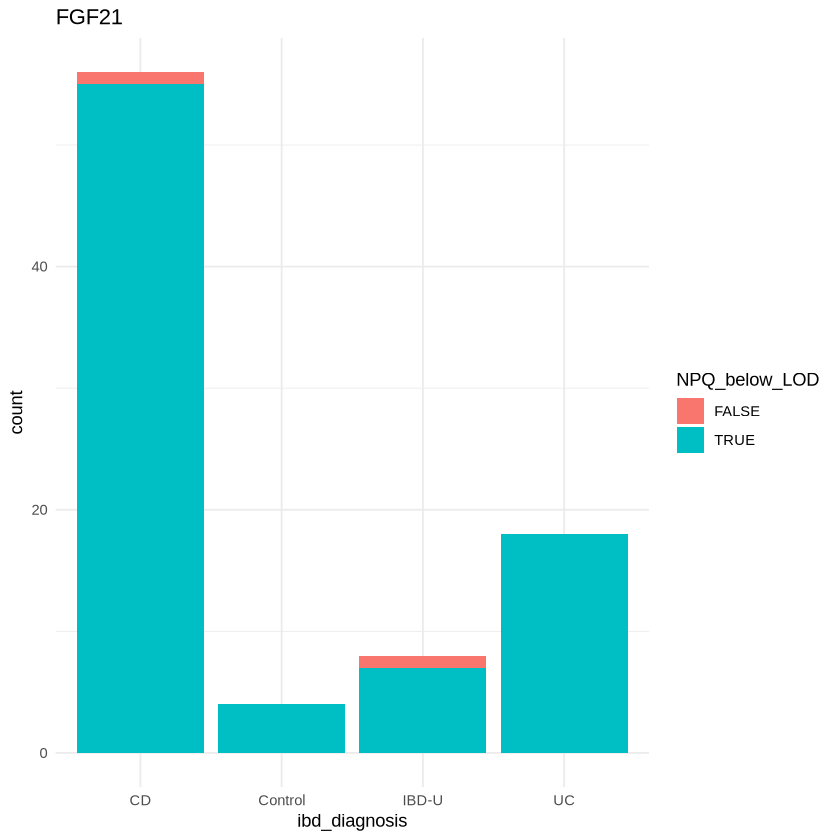

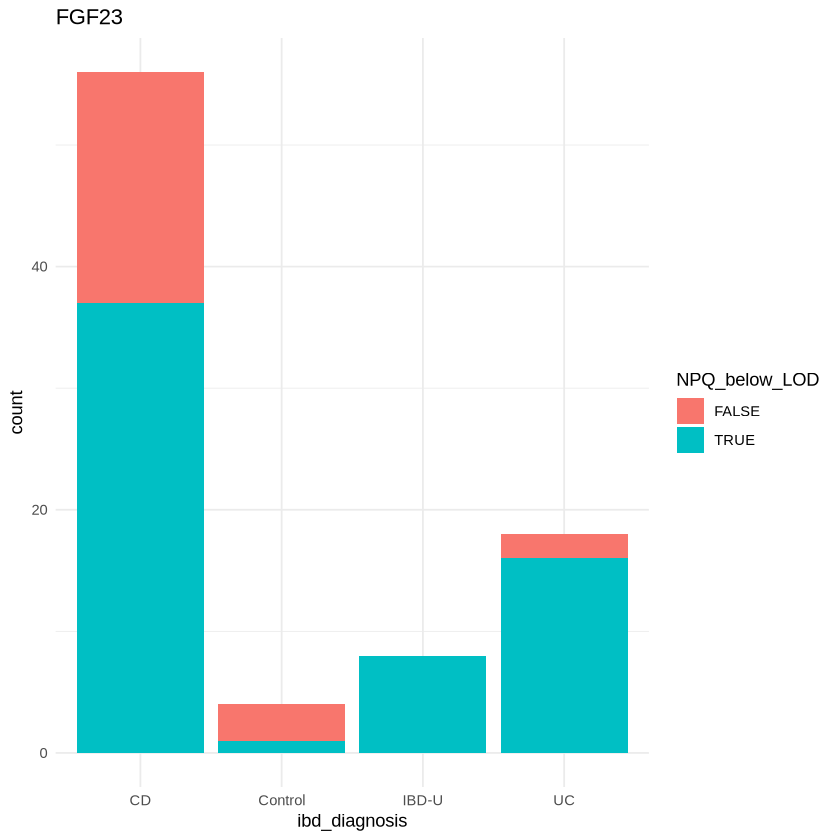

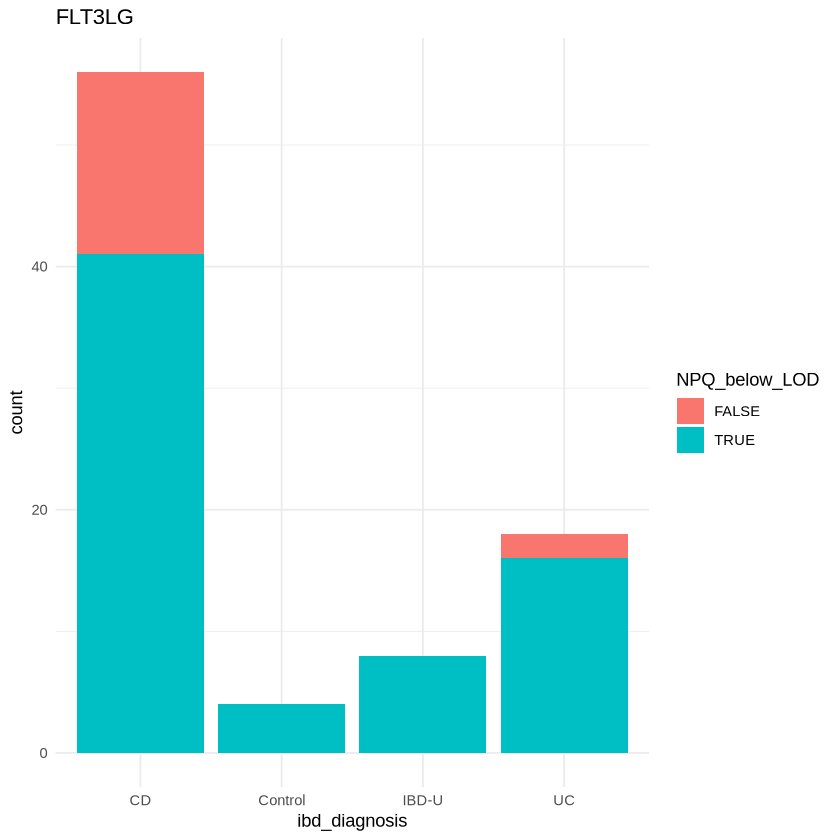

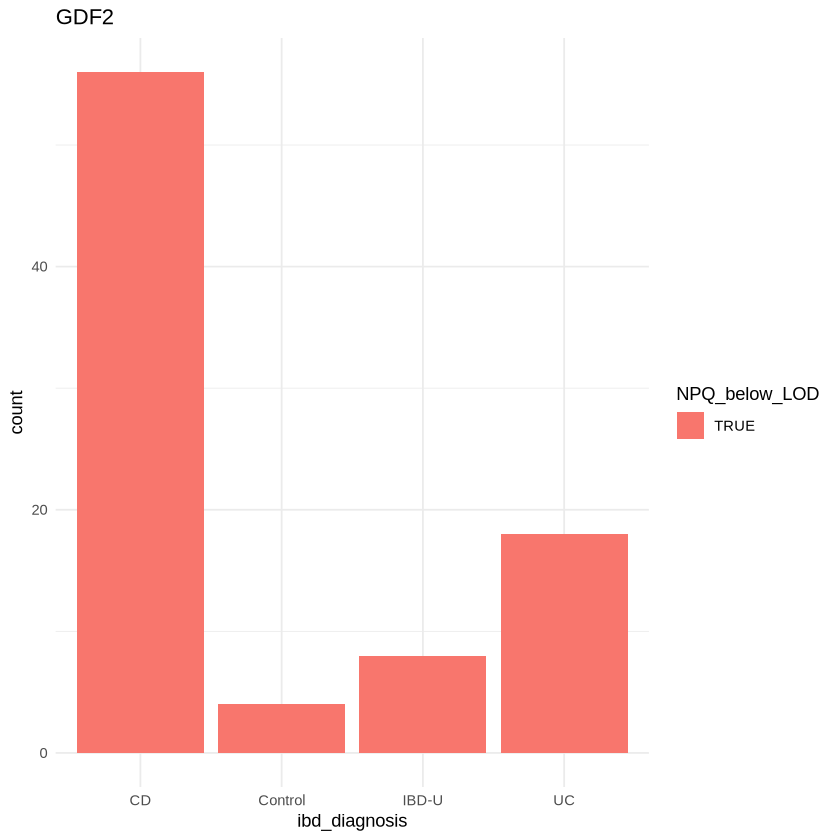

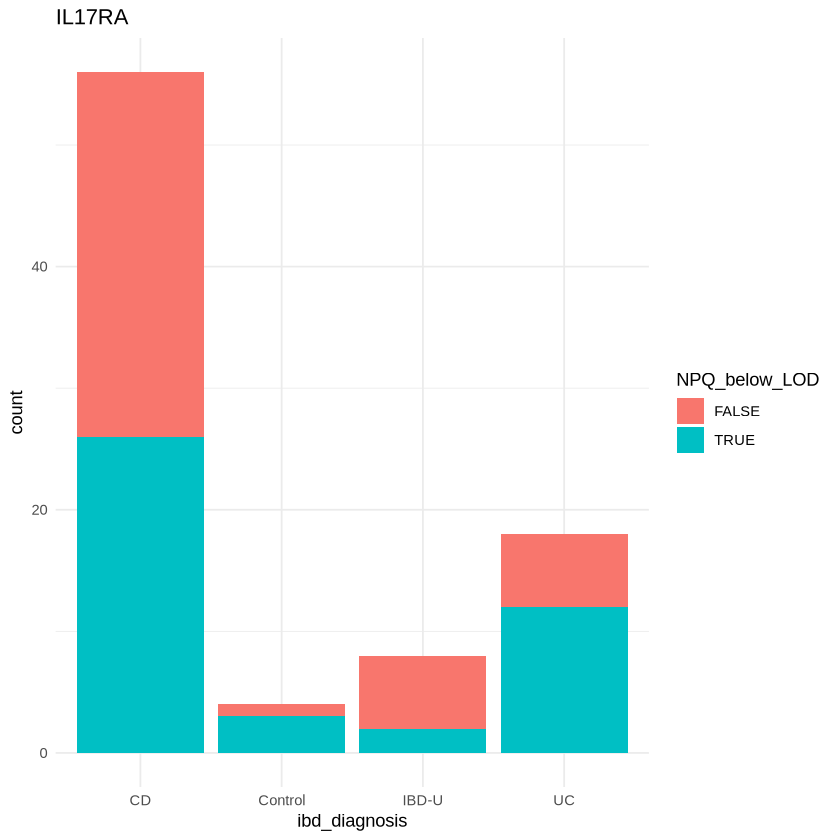

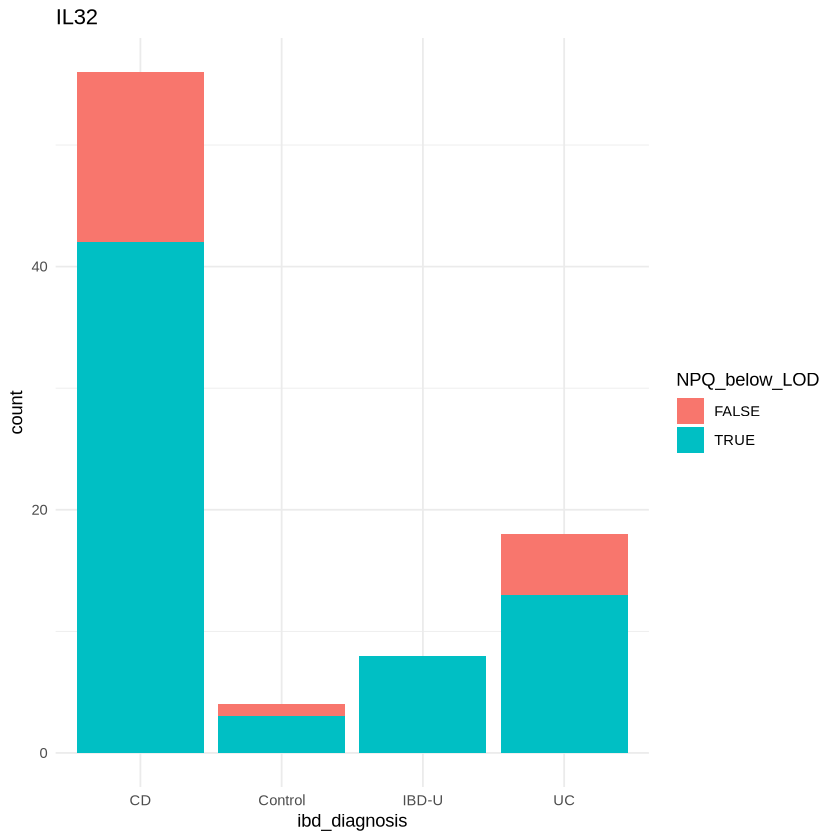

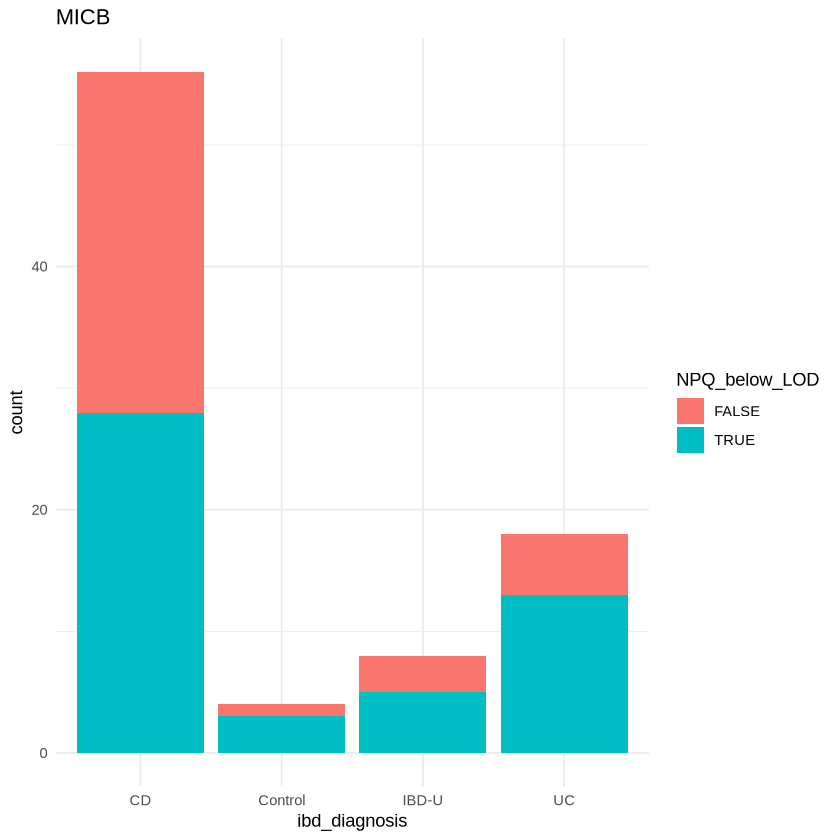

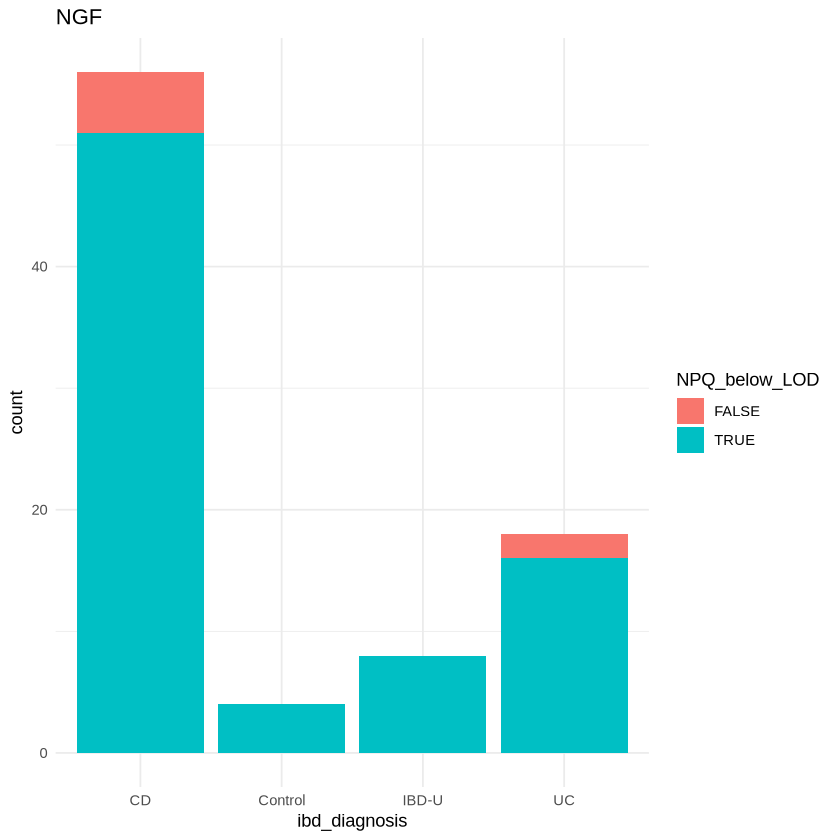

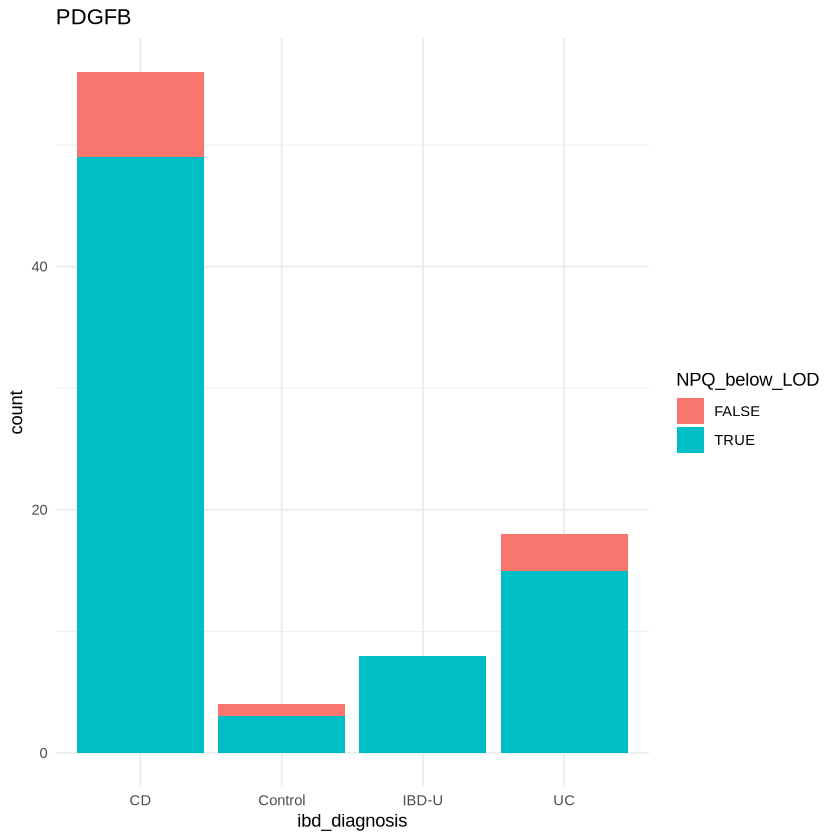

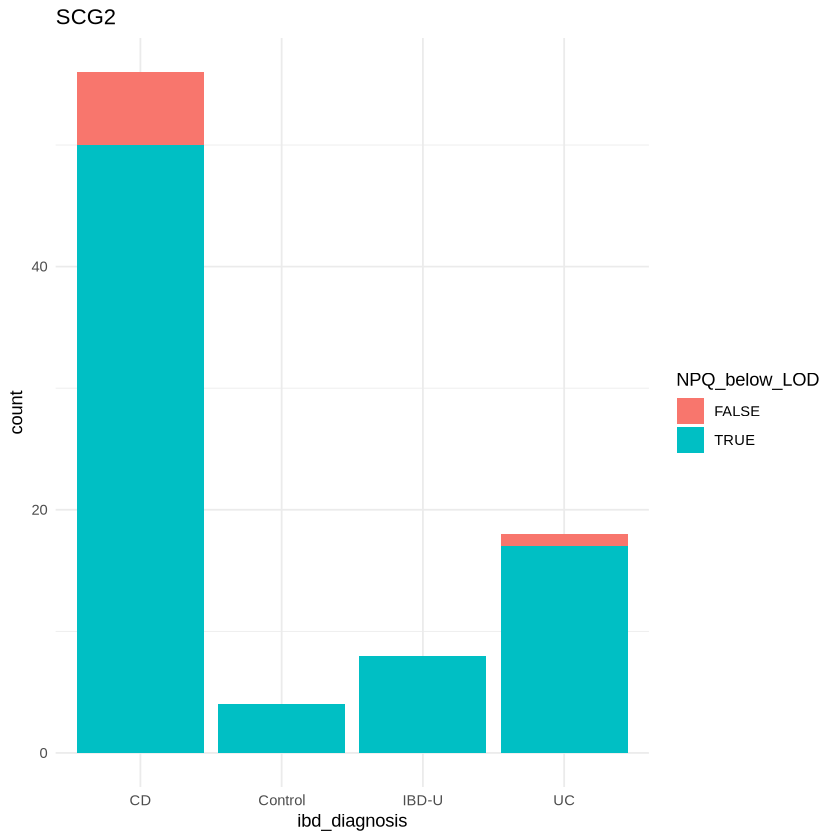

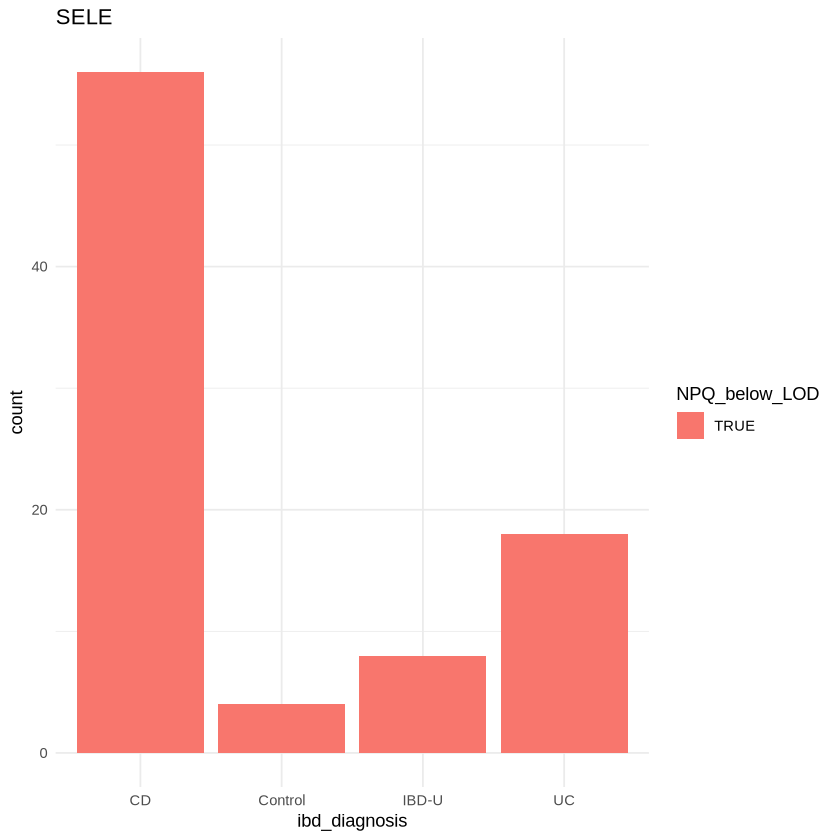

In [15]:
for (target in unique(low_filtered_data$Target)){

    # target = "FGF21"
    
    cdata <- low_filtered_data[low_filtered_data$Target == target,]
    cdata <- cdata %>% left_join(clinical_data, by = join_by(SampleName == sample_id))
    # cdata <- cdata[, c('ibd_diagnosis', 'NPQ')]

    #clean_df <- cdata %>% filter(!ibd_diagnosis %in% c("Alamar_Sample_Control", "IBD-U", "Control"))
    clean_df <- cdata %>% filter(!ibd_diagnosis %in% c("Alamar_Sample_Control"))


    clean_df <- clean_df %>% mutate(NPQ_below_LOD = NPQ < LOD)
    
    # Plot histogram
    # g <- ggplot(clean_df, aes(x = NPQ, fill = ibd_diagnosis)) +
    #   geom_histogram(position = "identity", alpha = 0.6, bins = 30) +
    #   labs(title = "Histogram of NPQ by Disease Status",
    #        x = "LOD",
    #        y = "Count",
    #        fill = "Diagnosis") +
    #   theme_minimal()

    g <- ggplot(clean_df, aes(x = ibd_diagnosis, fill = NPQ_below_LOD)) +
      geom_bar(position = "stack") +
      labs(title=target) +
      theme_minimal()


    print(g)

    # break
    
}

In [16]:
clean_df

Panel,PanelLotNumber,PlateID,SampleName,SampleType,Target,AlamarTargetID,UniProtID,ProteinName,SampleQC,⋯,ibd_diagnosis,date_collection,disease_activity,matched_subject_id,notes,ibd_indicator,disease_activity_indicator,max_crp_value,crp_severity,NPQ_below_LOD
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<int>,<lgl>,<chr>,<chr>,<dbl>,<chr>,<lgl>
200-Plex Inflammation Panel v2,panelLot022,Plate_01,TRP-34082,Sample,SELE,t8286,P16581,E-selectin,PASS,⋯,CD,2023-11-30,Quiescent,1,NA,IBD Super Group,In-active Disease,1.0,Mild,TRUE
200-Plex Inflammation Panel v2,panelLot022,Plate_01,TRP-34086,Sample,SELE,t8286,P16581,E-selectin,PASS,⋯,CD,2023-11-30,Quiescent,3,NA,IBD Super Group,In-active Disease,1.0,Mild,TRUE
200-Plex Inflammation Panel v2,panelLot022,Plate_01,TRP-42335,Sample,SELE,t8286,P16581,E-selectin,PASS,⋯,CD,2023-12-20,Quiescent,7,NA,IBD Super Group,In-active Disease,1.0,Mild,TRUE
200-Plex Inflammation Panel v2,panelLot022,Plate_01,TRP-42324,Sample,SELE,t8286,P16581,E-selectin,PASS,⋯,UC,2023-12-20,Quiescent,6,NA,IBD Super Group,In-active Disease,9.0,Moderate,TRUE
200-Plex Inflammation Panel v2,panelLot022,Plate_01,TRP-42322,Sample,SELE,t8286,P16581,E-selectin,PASS,⋯,CD,2023-12-20,Quiescent,5,NA,IBD Super Group,In-active Disease,1.0,Mild,TRUE
200-Plex Inflammation Panel v2,panelLot022,Plate_01,TRP-42320,Sample,SELE,t8286,P16581,E-selectin,PASS,⋯,CD,2023-12-20,Quiescent,4,NA,IBD Super Group,In-active Disease,23.0,High,TRUE
200-Plex Inflammation Panel v2,panelLot022,Plate_01,TRP-42344-2,Sample,SELE,t8286,P16581,E-selectin,PASS,⋯,CD,2024-01-03,Quiescent,8,NA,IBD Super Group,In-active Disease,9.0,Moderate,TRUE
200-Plex Inflammation Panel v2,panelLot022,Plate_01,TRP-42346,Sample,SELE,t8286,P16581,E-selectin,PASS,⋯,UC,2024-01-03,Moderate,9,NA,IBD Super Group,Active Disease,1.0,Mild,TRUE
200-Plex Inflammation Panel v2,panelLot022,Plate_01,TRP-42368-1,Sample,SELE,t8286,P16581,E-selectin,PASS,⋯,CD,2024-01-10,Quiescent,13,NA,IBD Super Group,In-active Disease,1.0,Mild,TRUE


In [17]:
table(clinical_data$ibd_diagnosis)


Alamar_Sample_Control                    CD               Control 
                    3                    56                     4 
                IBD-U                    UC 
                    8                    18 